# Logistic growth system identification

In [265]:
import numpy as np
import scipy
from scipy import linalg
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Generate data

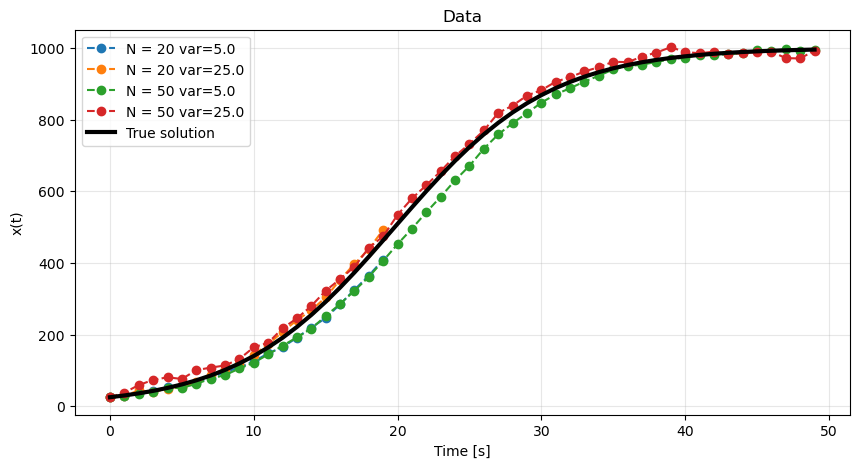

In [280]:
def logistic_rhs_noise(Nt, x0, var):
    dt = 1.0
    C = 1000
    r = 0.185
    x = 25.0
    sol = np.zeros(int(Nt/dt))
    sol[0] = x
    for time in range(1, int(Nt/dt)):
        x = x + dt * (r * x * (1 - x / C)) + np.random.randn() * np.sqrt(var)
        y = x + np.random.randn() * np.sqrt(var)
        sol[time] = y
    return np.arange(0, Nt, dt), sol

x_0 = 25.0

datasets = {}
for N in [20,50]:
    datasets[f"N = {N}"] = {}
    for var in [5.0, 25.0]:
        t_eval, sol = logistic_rhs_noise(N, x_0, var)
        datasets[f"N = {N}"][f"var={var}"] = {
            "t": t_eval,
            "y": sol 
        }

plt.figure(figsize=(10, 5))
for label, data in datasets.items():
    for var_label, data in data.items():
        plt.plot(data["t"], data["y"], 'o--', label=f'{label}'+ f' {var_label}')
t = np.arange(0, 50, 1.0)
y = (25 * 1000 * np.exp(0.185 * t))/((1000 - 25) + 25 * np.exp(0.185 * t))
plt.plot(t,y, label='True solution', color='k', linewidth=3)  
plt.xlabel('Time [s]')
plt.ylabel('x(t)')
plt.title('Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
def _log_gaussian_density(y, mu, S):
    d = len(y)
    diff = y - mu
    try:
        c, lower = linalg.cho_factor(S, check_finite=False)
        alpha = linalg.cho_solve((c, lower), diff)
        logdet = 2 * np.sum(np.log(np.diag(c)))
    except np.linalg.LinAlgError:
        alpha = np.linalg.solve(S, diff)
        logdet = np.log(np.linalg.det(S))
    return -0.5 * (diff.T @ alpha + logdet + d * np.log(2 * np.pi))

def loss_deterministicdynamics(theta, t_data, y_data, f, x0):
    sol = solve_ivp(lambda t, x: f(t, x, theta),
                    (t_data[0], t_data[-1]),
                    x0,
                    t_eval=t_data,
                    method='RK45')
    x_model = sol.y.T  # (n, d)
    residuals = y_data - x_model
    return np.sum(residuals**2)


def loss_nonmeasurementnoise(theta, y_data, f):
    residuals = np.array([y_data[i] - f(y_data[i-1], theta) for i in range(1, len(y_data))])
    return np.sum(residuals**2)

def linearkalman(theta, Y, m0, P0, prior_logpdf, A_fn, H_fn, Sigma_fn, Gamma_fn):
    Y = np.asarray(Y)
    n, m = Y.shape

    log_prior = prior_logpdf(theta)
    logL = 0.0

    mk = m0.copy()
    Pk = P0.copy()

    for k in range(n):
        # Predict
        A = np.atleast_2d(A_fn(theta))
        Sigma = np.atleast_2d(Sigma_fn(theta))
        m_minus = A @ mk
        P_minus = A @ Pk @ A.T + Sigma

        # Evidence
        H = np.atleast_2d(H_fn(theta))
        Gamma = np.atleast_2d(Gamma_fn(theta))
        mu_k = H @ m_minus
        S_k = H @ P_minus @ H.T + Gamma

        yk = Y[k]
        logp = _log_gaussian_density(yk, mu_k, S_k)
        logL += logp

        # Update
        try:
            c, lower = linalg.cho_factor(S_k, check_finite=False)
            S_inv_HT = linalg.cho_solve((c, lower), H.T, check_finite=False)
        except np.linalg.LinAlgError:
            S_inv_HT = np.linalg.inv(S_k) @ H.T

        K = P_minus @ S_inv_HT
        innovation = yk - mu_k
        mk = m_minus + K @ innovation
        Pk = P_minus - K @ H @ P_minus
        Pk = (Pk + Pk.T) / 2.0
        Pk += 1e-8 * np.eye(Pk.shape[0])

    log_post = log_prior + logL
    return {
        'log_prior': log_prior,
        'log_likelihood': logL,
        'log_posterior': log_post,
        'prediction': (mk, Pk)
    }


In [17]:


def unscentedkalman(theta, Y, m0, P0, prior_logpdf,
                          Phi, h, Sigma_fn, Gamma_fn,
                          alpha=1e-3, beta=2.0, kappa=0.0):
    Y = np.asarray(Y)
    n, m = Y.shape
    d = m0.shape[0]
    log_prior = prior_logpdf(theta)

    mk = m0.astype(np.float64).copy()
    Pk = P0.astype(np.float64).copy()
    logL = 0.0

    lambd = alpha**2 * (d + kappa) - d
    denom = d + lambd
    w0m = lambd / denom
    w0c = w0m + (1 - alpha**2 + beta)
    wim = 1.0 / (2.0 * denom)
    sqrt_d_lamb = np.sqrt(denom)

    for k in range(n):
        # Predict
        try:
            A = np.linalg.cholesky(Pk)
        except np.linalg.LinAlgError:
            A = np.linalg.cholesky(Pk + 1e-8 * np.eye(d))

        x_points = np.empty((d, 2*d + 1))
        x_points[:, 0] = mk
        for i in range(d):
            col = A[:, i]
            x_points[:, 1 + i] = mk + sqrt_d_lamb * col
            x_points[:, 1 + d + i] = mk - sqrt_d_lamb * col

        x_hat_points = np.empty_like(x_points)
        for i in range(2*d + 1):
            x_hat_points[:, i] = Phi(x_points[:, i], theta)

        m_minus = w0m * x_hat_points[:, 0] + wim * np.sum(x_hat_points[:, 1:], axis=1)
        P_minus = np.atleast_2d(Sigma_fn(theta)).astype(np.float64)
        for i in range(2*d + 1):
            diff = x_hat_points[:, i] - m_minus
            if i == 0:
                P_minus += w0c * np.outer(diff, diff)
            else:
                P_minus += wim * np.outer(diff, diff)
        P_minus = (P_minus + P_minus.T) / 2.0

        # Measurement
        try:
            A2 = np.linalg.cholesky(P_minus)
        except np.linalg.LinAlgError:
            A2 = np.linalg.cholesky(P_minus + 1e-8 * np.eye(d))

        x_points2 = np.empty((d, 2*d + 1))
        x_points2[:, 0] = m_minus
        for i in range(d):
            col = A2[:, i]
            x_points2[:, 1 + i] = m_minus + sqrt_d_lamb * col
            x_points2[:, 1 + d + i] = m_minus - sqrt_d_lamb * col

        y_hat_points = np.empty((m, 2*d + 1))
        for i in range(2*d + 1):
            y_hat_points[:, i] = h(x_points2[:, i], theta)

        mu_k = w0m * y_hat_points[:, 0] + wim * np.sum(y_hat_points[:, 1:], axis=1)
        S_k = np.atleast_2d(Gamma_fn(theta)).astype(np.float64)
        for i in range(2*d + 1):
            diffy = y_hat_points[:, i] - mu_k
            if i == 0:
                S_k += w0c * np.outer(diffy, diffy)
            else:
                S_k += wim * np.outer(diffy, diffy)
        S_k = (S_k + S_k.T) / 2.0

        yk = Y[k]
        logL += _log_gaussian_density(yk, mu_k, S_k)

        # Update
        C_k = np.zeros((d, m))
        for i in range(2*d + 1):
            dx = x_points2[:, i] - m_minus
            dy = y_hat_points[:, i] - mu_k
            if i == 0:
                C_k += w0c * np.outer(dx, dy)
            else:
                C_k += wim * np.outer(dx, dy)

        try:
            cho = np.linalg.cholesky(S_k)
            K = np.linalg.cho_solve((cho, True), C_k.T).T
        except Exception:
            S_inv = np.linalg.inv(S_k)
            K = C_k @ S_inv

        mk = m_minus + K @ (yk - mu_k)
        Pk = P_minus - K @ C_k.T
        Pk = (Pk + Pk.T) / 2.0

    return {
        'log_prior': log_prior,
        'log_likelihood': logL,
        'log_posterior': log_prior + logL,
        'prediction': (mk, Pk)
    }


## Bayesian system identification

Sampling progress: 100%|██████████| 2050/2050 [04:26<00:00,  7.69 draws/s]
C:\Users\carlo\AppData\Local\Temp\ipykernel_13684\2818386786.py:186: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i,j] = P_i[j][0]


[2.02791249e-01 9.52383884e+02 3.51542448e+00 9.07352638e+00]


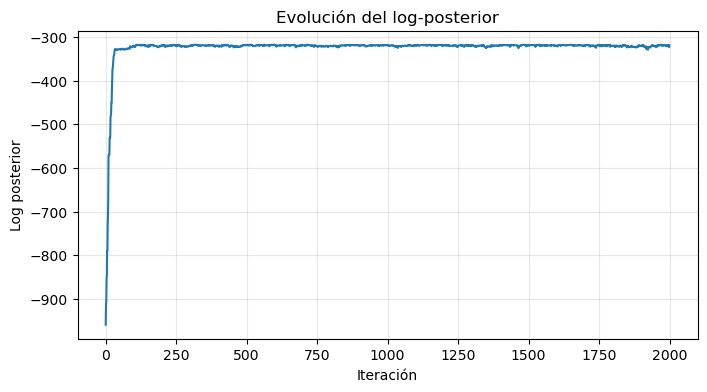

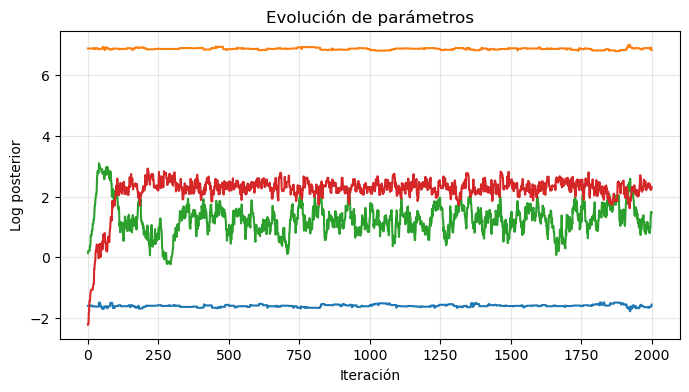

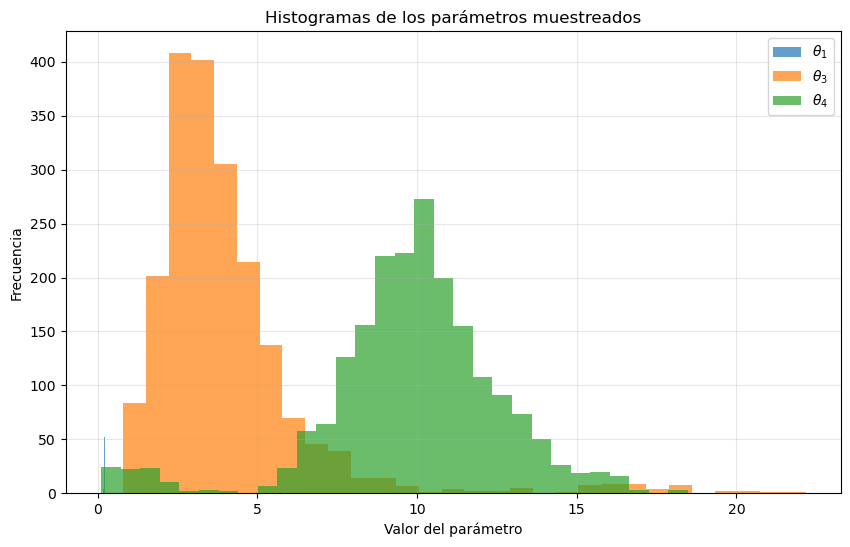

In [69]:
def unscentedkalman(theta, Y, m0, P0, prior_logpdf,
                          Phi, h, Sigma_fn, Gamma_fn,
                          alpha=1e-3, beta=2.0, kappa=0.0):
    Y = np.asarray(Y)
    if Y.ndim == 1:
        Y = Y[:, None]
    n, m = Y.shape
    d = m0.shape[0]
    log_prior = prior_logpdf(theta)

    mk = m0.astype(np.float64).copy()
    Pk = P0.astype(np.float64).copy()
    logL = 0.0

    lambd = alpha**2 * (d + kappa) - d
    denom = d + lambd
    w0m = lambd / denom
    w0c = w0m + (1 - alpha**2 + beta)
    wim = 1.0 / (2.0 * denom)
    sqrt_d_lamb = np.sqrt(denom)

    history = {'m':[], 'P':[]}
    for k in range(n):
        # Predict
        try:
            A = np.linalg.cholesky(Pk)
        except np.linalg.LinAlgError:
            A = np.linalg.cholesky(Pk + 1e-8 * np.eye(d))

        x_points = np.empty((d, 2*d + 1))
        x_points[:, 0] = mk
        for i in range(d):
            col = A[:, i]
            x_points[:, 1 + i] = mk + sqrt_d_lamb * col
            x_points[:, 1 + d + i] = mk - sqrt_d_lamb * col

        x_hat_points = np.empty_like(x_points)
        for i in range(2*d + 1):
            x_hat_points[:, i] = Phi(x_points[:, i], theta)

        m_minus = w0m * x_hat_points[:, 0] + wim * np.sum(x_hat_points[:, 1:], axis=1)
        P_minus = np.atleast_2d(Sigma_fn(theta)).astype(np.float64)
        for i in range(2*d + 1):
            diff = x_hat_points[:, i] - m_minus
            if i == 0:
                P_minus += w0c * np.outer(diff, diff)
            else:
                P_minus += wim * np.outer(diff, diff)
        P_minus = (P_minus + P_minus.T) / 2.0

        # Measurement
        try:
            A2 = np.linalg.cholesky(P_minus)
        except np.linalg.LinAlgError:
            A2 = np.linalg.cholesky(P_minus + 1e-8 * np.eye(d))

        x_points2 = np.empty((d, 2*d + 1))
        x_points2[:, 0] = m_minus
        for i in range(d):
            col = A2[:, i]
            x_points2[:, 1 + i] = m_minus + sqrt_d_lamb * col
            x_points2[:, 1 + d + i] = m_minus - sqrt_d_lamb * col

        y_hat_points = np.empty((m, 2*d + 1))
        for i in range(2*d + 1):
            y_hat_points[:, i] = h(x_points2[:, i], theta)

        mu_k = w0m * y_hat_points[:, 0] + wim * np.sum(y_hat_points[:, 1:], axis=1)
        S_k = np.atleast_2d(Gamma_fn(theta)).astype(np.float64)
        for i in range(2*d + 1):
            diffy = y_hat_points[:, i] - mu_k
            if i == 0:
                S_k += w0c * np.outer(diffy, diffy)
            else:
                S_k += wim * np.outer(diffy, diffy)
        S_k = (S_k + S_k.T) / 2.0

        yk = np.atleast_1d(Y[k])
        logL += _log_gaussian_density(yk, mu_k, S_k)

        # Update
        C_k = np.zeros((d, m))
        for i in range(2*d + 1):
            dx = x_points2[:, i] - m_minus
            dy = y_hat_points[:, i] - mu_k
            if i == 0:
                C_k += w0c * np.outer(dx, dy)
            else:
                C_k += wim * np.outer(dx, dy)

        try:
            cho = np.linalg.cholesky(S_k)
            K = np.linalg.cho_solve((cho, True), C_k.T).T
        except Exception:
            S_inv = np.linalg.inv(S_k)
            K = C_k @ S_inv

        mk = m_minus + K @ (yk - mu_k)
        Pk = P_minus - K @ C_k.T
        Pk = (Pk + Pk.T) / 2.0
        history['m'].append(mk.copy())
        history['P'].append(Pk.copy())

    return {
        'log_prior': log_prior,
        'log_likelihood': logL,
        'log_posterior': log_prior + logL,
        'prediction': history
    }



def bayeslogistics(params):
    # Initialzation
    t , y = params['t'], params['y']
    dt = t[1] - t[0]
    N = len(y)
    number_of_parameters = 4
    number_of_samples = params['number_of_samples']
    number_of_thining = params['number_of_thining']
    number_of_burnin = params['number_of_burnin']
    current_theta = params['initial_theta']
    q = params['proposal_std']
    
    # Kalman filter setup
    m0 = params['initial_system_mean']
    P0 = params['initial_system_covariance']
    def prior_logpdf(theta):
        return -0.5 * np.sum(theta**2)
    def Phi(x,theta):
        r = np.exp(theta[0])
        C = np.exp(theta[1])
        x_new = x + dt * (r * x * (1 - x / C))
        return np.array([max(x_new, 1e-6)])
    def h(x,theta): return np.array([x])
    def Sigma(theta): return np.array([[np.exp(theta[2])]])
    def Gamma(theta): return np.array([[np.exp(theta[3])]])
    
    history = []

    kf = unscentedkalman(current_theta, y, m0, P0, prior_logpdf, Phi, h, Sigma, Gamma)
    current_posterior = kf['log_posterior']
    history.append(kf['prediction'])


    theta = np.zeros((number_of_samples, number_of_parameters))
    posterior = np.zeros(number_of_samples)

    acceptance_history = np.zeros((number_of_samples * number_of_thining + number_of_burnin, number_of_parameters))

    for draw in tqdm(range(number_of_samples * number_of_thining + number_of_burnin), desc="Sampling progress", unit=" draws"):
        for _param in range(number_of_parameters):
            # Proposal
            proposed_theta = current_theta.copy()
            proposed_theta[_param] += q[_param] * np.random.normal()
            kfproposed = unscentedkalman(proposed_theta, y, m0, P0, prior_logpdf, Phi, h, Sigma, Gamma)
            proposed_posterior = kfproposed['log_posterior']
            # Metropolis-Hastings acceptance criterion
            log_acceptance_ratio = proposed_posterior - current_posterior
            if np.log(np.random.rand()) < log_acceptance_ratio:
                current_theta = proposed_theta
                current_posterior = proposed_posterior
                acceptance_history[draw, _param] = 1
                history.append(kfproposed['prediction'])
            else:
                history.append(history[-1])
            # Tunning of proposal std
            if draw <= number_of_burnin and draw % 2 == 0 and draw > 0:
                acep_param = np.sum(acceptance_history[:draw, _param]) / (draw + 1)
                q[_param] *= np.exp(0.01 * (acep_param - 0.45))
            
        # Store samples after burn-in and thinning
        if draw >= number_of_burnin and (draw - number_of_burnin) % number_of_thining == 0:
            index = (draw - number_of_burnin) // number_of_thining
            theta[index, :] = current_theta
            posterior[index] = current_posterior
    
    history = history[number_of_burnin:number_of_burnin + number_of_samples * number_of_thining:number_of_thining]
    m = np.zeros((number_of_samples,N))
    P = np.zeros((number_of_samples,N))
    for i, dic in enumerate(history):
        m_i = dic['m']
        P_i = dic['P']
        for j in range(N):
            m[i,j] = m_i[j][0]
            P[i,j] = P_i[j][0]
            
    return {'theta_samples': theta, 'posterior_samples': posterior, 'proposal_std': q, 'acceptance_history': acceptance_history, 'm': m, 'P': P}

params = {
    "t": datasets["N = 100"]["var=10.0"]["t"],
    "y": datasets["N = 100"]["var=10.0"]["y"],
    "number_of_samples": 2000,
    "number_of_thining": 1,
    "number_of_burnin": 50,
    "initial_theta": np.array([np.log(0.5), np.log(500), np.log(0.01), np.log(0.01)]),
    "proposal_std": np.array([0.2, 0.2, 0.2, 0.2]),
    "initial_system_mean": np.array([25.0]),
    "initial_system_covariance": np.array([[0.1]])
}

results = bayeslogistics(params)

theta_samples = results["theta_samples"]
posterior = results["posterior_samples"]

print(np.exp(np.mean(theta_samples, axis=0)))

plt.figure(figsize=(8,4))
plt.plot(posterior)
plt.title("Evolución del log-posterior")
plt.xlabel("Iteración")
plt.ylabel("Log posterior")
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(8,4))
plt.plot(theta_samples)
plt.title("Evolución de parámetros")
plt.xlabel("Iteración")
plt.ylabel("Log posterior")
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(np.exp(theta_samples[:, 0]), bins=30, alpha=0.7, label=r'$\theta_1$')
#plt.hist(np.exp(theta_samples[:, 1]), bins=30, alpha=0.7, label=r'$\theta_2$')
plt.hist(np.exp(theta_samples[:, 2]), bins=30, alpha=0.7, label=r'$\theta_3$')
plt.hist(np.exp(theta_samples[:, 3]), bins=30, alpha=0.7, label=r'$\theta_4$')
plt.title("Histogramas de los parámetros muestreados")                  
plt.xlabel("Valor del parámetro")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## $\Sigma=0$ estimation

Sampling progress: 100%|██████████| 25000/25000 [00:42<00:00, 585.28 draws/s]


[1.67516621e-01 1.00370486e+03]


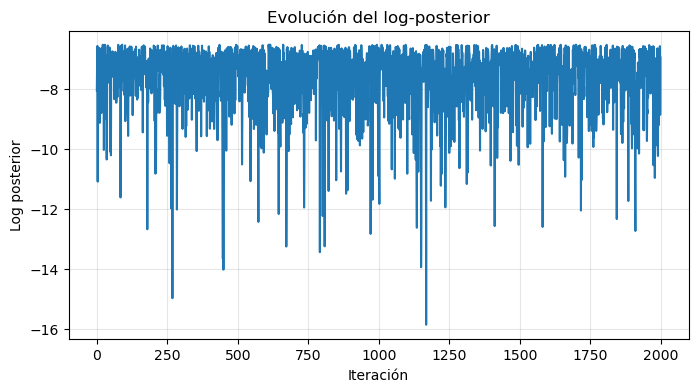

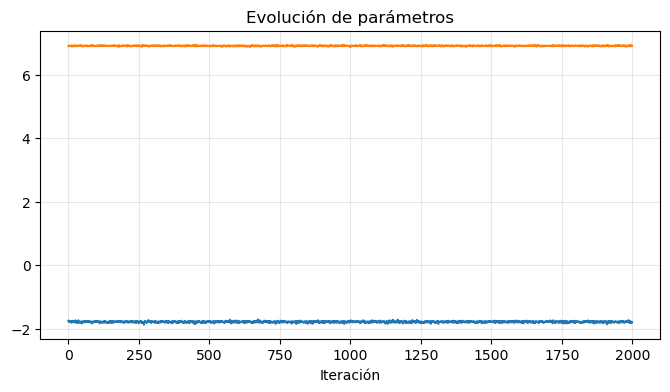

In [98]:
def deterministicdynamicslogistics(params):
    def loss_deterministicdynamics(theta, t_data, y_data, x0):
        r, C = theta
        sol = [(x0*C*np.exp(r*t))/((C-x0) + x0*np.exp(r*t) + 1e-6) for t in t_data]
        residuals = np.abs(y_data - sol)
        return -0.5*np.mean(residuals)
    

    # Initialzation
    t , y = params['t'], params['y']
    dt = t[1] - t[0]

    number_of_parameters = 2
    number_of_samples = params['number_of_samples']
    number_of_thining = params['number_of_thining']
    number_of_burnin = params['number_of_burnin']
    current_theta = params['initial_theta']
    q = params['proposal_std']
    
    # Setup
    m0 = params['initial_system']
    def prior_logpdf(theta):
        return 0.0

    current_posterior = loss_deterministicdynamics(current_theta, t, y, m0[0]) + prior_logpdf(current_theta)

    theta = np.zeros((number_of_samples, number_of_parameters))
    posterior = np.zeros(number_of_samples)

    acceptance_history = np.zeros((number_of_samples * number_of_thining + number_of_burnin, number_of_parameters))

    for draw in tqdm(range(number_of_samples * number_of_thining + number_of_burnin), desc="Sampling progress", unit=" draws"):
        for _param in range(number_of_parameters):
            # Proposal
            proposed_theta = current_theta.copy()
            proposed_theta[_param] += q[_param] * np.random.normal()
            proposed_posterior = loss_deterministicdynamics(proposed_theta, t, y, m0[0]) + prior_logpdf(proposed_theta)
            # Metropolis-Hastings acceptance criterion
            log_acceptance_ratio = proposed_posterior - current_posterior
            if np.log(np.random.rand()) < log_acceptance_ratio:
                current_theta = proposed_theta
                current_posterior = proposed_posterior
                acceptance_history[draw, _param] = 1
            # Tunning of proposal std
            if draw <= number_of_burnin and draw % 2 == 0 and draw > 0:
                acep_param = np.sum(acceptance_history[:draw, _param]) / (draw + 1)
                q[_param] *= np.exp(0.01 * (acep_param - 0.45))
            
        # Store samples after burn-in and thinning
        if draw >= number_of_burnin and (draw - number_of_burnin) % number_of_thining == 0:
            index = (draw - number_of_burnin) // number_of_thining
            theta[index, :] = current_theta
            posterior[index] = current_posterior
            
    return {'theta_samples': theta, 'posterior_samples': posterior, 'proposal_std': q, 'acceptance_history': acceptance_history}

params_deterministicdynamics = {
    "t": datasets["N = 300"]["var=10.0"]["t"],
    "y": datasets["N = 300"]["var=10.0"]["y"],
    "number_of_samples": 2000,
    "number_of_thining": 10,
    "number_of_burnin": 5000,
    "initial_theta": np.array([0.5, 500]),
    "proposal_std": np.array([0.05, 10.0]),
    "initial_system": np.array([25.0]),
}

results_deterministicdynamics = deterministicdynamicslogistics(params_deterministicdynamics)

theta_samples = results_deterministicdynamics["theta_samples"]
posterior = results_deterministicdynamics["posterior_samples"]

print(np.mean(theta_samples[:, :4], axis=0))

plt.figure(figsize=(8,4))
plt.plot(posterior)
plt.title("Evolución del log-posterior")
plt.xlabel("Iteración")
plt.ylabel("Log posterior")
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(8,4))
plt.plot(np.log(theta_samples))
plt.title("Evolución de parámetros")
plt.xlabel("Iteración")
plt.grid(True, alpha=0.3)
plt.show()

## $\Gamma=0$ estimation

Sampling progress: 100%|██████████| 25000/25000 [00:21<00:00, 1179.77 draws/s]


[2.11338816e-01 1.05260423e+03]


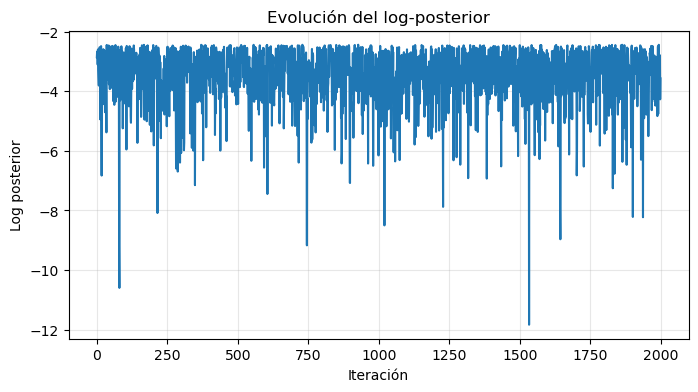

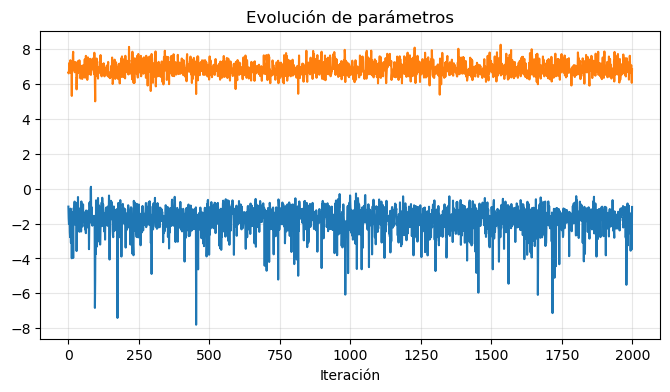

In [116]:
def nonmeasurementnoiselogistics(params):
    def loss_nonmeasurementnoise(theta, y_data, f):
        residuals = np.array([y_data[i] - f(y_data[i-1], theta) for i in range(1, len(y_data))])
        residuals = np.abs(residuals)
        return -0.5*np.mean(residuals)
    

    # Initialzation
    t , y = params['t'], params['y']
    dt = t[1] - t[0]

    number_of_parameters = 2
    number_of_samples = params['number_of_samples']
    number_of_thining = params['number_of_thining']
    number_of_burnin = params['number_of_burnin']
    current_theta = params['initial_theta']
    q = params['proposal_std']
    
    # Setup
    m0 = params['initial_system']
    def Phi(x,theta):
        r = theta[0]
        C = theta[1]
        x_new = x + dt * (r * x * (1 - x / C))
        return np.array([max(x_new, 1e-6)])
    def prior_logpdf(theta):
        p = 0.0
        if theta[1] <= 0 or theta[0] <= 0:
            p += -1e10
        p += -0.5 * theta[1]**2 / 1000.0**2
        return p

    current_posterior = loss_nonmeasurementnoise(current_theta, y, Phi) + prior_logpdf(current_theta)

    theta = np.zeros((number_of_samples, number_of_parameters))
    posterior = np.zeros(number_of_samples)

    acceptance_history = np.zeros((number_of_samples * number_of_thining + number_of_burnin, number_of_parameters))

    for draw in tqdm(range(number_of_samples * number_of_thining + number_of_burnin), desc="Sampling progress", unit=" draws"):
        for _param in range(number_of_parameters):
            # Proposal
            proposed_theta = current_theta.copy()
            proposed_theta[_param] += q[_param] * np.random.normal()
            proposed_posterior = loss_nonmeasurementnoise(proposed_theta, y, Phi)+ prior_logpdf(proposed_theta)
            # Metropolis-Hastings acceptance criterion
            log_acceptance_ratio = proposed_posterior - current_posterior
            if np.log(np.random.rand()) < log_acceptance_ratio:
                current_theta = proposed_theta
                current_posterior = proposed_posterior
                acceptance_history[draw, _param] = 1
            # Tunning of proposal std
            if draw <= number_of_burnin and draw % 2 == 0 and draw > 0:
                acep_param = np.sum(acceptance_history[:draw, _param]) / (draw + 1)
                q[_param] *= np.exp(0.01 * (acep_param - 0.45))
            
        # Store samples after burn-in and thinning
        if draw >= number_of_burnin and (draw - number_of_burnin) % number_of_thining == 0:
            index = (draw - number_of_burnin) // number_of_thining
            theta[index, :] = current_theta
            posterior[index] = current_posterior
            
    return {'theta_samples': theta, 'posterior_samples': posterior, 'proposal_std': q, 'acceptance_history': acceptance_history}

params_nonmeasurementnoise = {
    "t": datasets["N = 100"]["var=10.0"]["t"],
    "y": datasets["N = 100"]["var=10.0"]["y"],
    "number_of_samples": 2000,
    "number_of_thining": 10,
    "number_of_burnin": 5000,
    "initial_theta": np.array([0.5, 500]),
    "proposal_std": np.array([0.05, 100.0]),
    "initial_system": np.array([25.0]),
}

results_nonmeasurementnoise = nonmeasurementnoiselogistics(params_nonmeasurementnoise)

theta_samples = results_nonmeasurementnoise["theta_samples"]
posterior = results_nonmeasurementnoise["posterior_samples"]

print(np.mean(theta_samples, axis=0))

plt.figure(figsize=(8,4))
plt.plot(posterior)
plt.title("Evolución del log-posterior")
plt.xlabel("Iteración")
plt.ylabel("Log posterior")
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(8,4))
plt.plot(np.log(theta_samples))
plt.title("Evolución de parámetros")
plt.xlabel("Iteración")
plt.grid(True, alpha=0.3)
plt.show()

In [113]:
np.mean(theta_samples, axis=0)[1]

40.034745374547335

## All estimations

In [268]:
# All estimations function
def allestimations(N, sigma, samples=2000, thining=10, burnin=5000, datasets=datasets):
    t, y = datasets[f"N = {N}"][f"var={sigma}"]["t"], datasets[f"N = {N}"][f"var={sigma}"]["y"]
    idx_train = int(0.8 *len(t))
    t_train, y_train = t[:idx_train], y[:idx_train]
    t_test,  y_test  = t[idx_train:], y[idx_train:]
    dt = 1.0
    r_true = 0.185
    C_true = 1000
    x0_true = 25

    # Solución exacta logística
    def logistic_solution(t, r, C, x0):
        return (C * x0 * np.exp(r * t)) / (C + x0 * (np.exp(r * t) - 1))

    # Simulación del mapa logístico
    def simulate_logistic_trajectory(t, r, C, x0):
        x = np.zeros(len(t)+1)
        x[0] = x0
        
        for k in range(1, len(t)+1):
            x[k] = x[k-1] + dt * (r * x[k-1] * (1 - x[k-1]/C))
        return x[1:]

    # -----------------------------
    # Estimation 1: deterministic dynamics
    # -----------------------------
    print("Sigma = 0 estimation")

    params_deterministicdynamics = {
        "t": t_train,
        "y": y_train,
        "number_of_samples": samples,
        "number_of_thining": thining,
        "number_of_burnin": burnin,
        "initial_theta": np.array([0.5, 500]),
        "proposal_std": np.array([0.05, 10.0]),
        "initial_system": np.array([25.0]),
    }

    results_deterministicdynamics = deterministicdynamicslogistics(params_deterministicdynamics)
    estimator_det = np.mean(results_deterministicdynamics['theta_samples'], axis=0)

    # -----------------------------
    # Estimation 2: non-measurement noise
    # -----------------------------
    print("Gamma = 0 estimation")

    params_nonmeasurementnoise = {
        "t": t_train,
        "y": y_train,
        "number_of_samples": samples,
        "number_of_thining": thining,
        "number_of_burnin": burnin,
        "initial_theta": np.array([0.5, 500]),
        "proposal_std": np.array([0.05, 10.0]),
        "initial_system": np.array([25.0]),
    }

    results_nonmeasurementnoise = nonmeasurementnoiselogistics(params_nonmeasurementnoise)
    estimator_non = np.mean(results_nonmeasurementnoise['theta_samples'], axis=0)

    # -----------------------------
    # Estimation 3: bayesian
    # -----------------------------
    print("Sigma != 0, Gamma != 0 estimation")

    params_bayes = {
        "t": t_train,
        "y": y_train,
        "number_of_samples": samples,
        "number_of_thining": thining,
        "number_of_burnin": burnin,
        "initial_theta": np.array([np.log(0.5), np.log(500), np.log(10.0), np.log(10.0)]),
        "proposal_std": np.array([0.2, 0.2, 0.2, 0.2]),
        "initial_system_mean": np.array([25.0]),
        "initial_system_covariance": np.array([[1.0]])
    }

    results_bayes = bayeslogistics(params_bayes)
    theta_bayes_raw = results_bayes['theta_samples']
    theta_bayes = np.exp(np.mean(theta_bayes_raw, axis=0))
    estimator_bayes = theta_bayes  
    m = results_bayes["m"]
    P = results_bayes["P"]

    # ============================
    # Figure 1
    # ============================

    plt.figure(figsize=(12,4))

    # Histogram r
    plt.subplot(1,2,1)
    plt.hist(np.exp(theta_bayes_raw[:,0]), bins=40, alpha=0.4, label="", density=True)
    plt.axvline(r_true, color="k", linestyle="--", label="True value")
    plt.axvline(estimator_det[0], color="r", label=r"$\Sigma = 0$")
    plt.axvline(estimator_non[0], color="g", label=r"$\Gamma = 0$")
    plt.axvline(estimator_bayes[0], color="b", label=r"$\Sigma \neq 0, \Gamma \neq 0$")
    plt.title("")
    plt.xlabel("r")
    plt.xlim(0.001, 0.5)
    plt.legend()

    # Histogram C
    plt.subplot(1,2,2)
    plt.hist(np.exp(theta_bayes_raw[:,1]), bins=40, alpha=0.4, label="", density=True)
    plt.axvline(C_true, color="k", linestyle="--", label="True value")
    plt.axvline(estimator_det[1], color="r", label=r"$\Sigma = 0$")
    plt.axvline(estimator_non[1], color="g", label=r"$\Gamma = 0$")
    plt.axvline(estimator_bayes[1], color="b", label=r"$\Sigma \neq 0, \Gamma \neq 0$")
    plt.title("")
    plt.xlabel("C")
    plt.xlim(300, 1700)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ============================
    # Figure 2
    # ============================

    x_true_train = logistic_solution(t_train, r_true, C_true, x0_true)

    # Predicciones
    mean_path = np.mean(m, axis=0)
    std_path  = np.sqrt(np.mean(P, axis=0))
    upper = mean_path + 10*std_path
    lower = mean_path - 10*std_path

    x_det = simulate_logistic_trajectory(t_train, estimator_det[0], estimator_det[1], x0_true)
    x_non = simulate_logistic_trajectory(t_train, estimator_non[0], estimator_non[1], x0_true)
    x_bayes_path = mean_path 

    
    plt.figure(figsize=(10,5))
    plt.scatter(t_train, y_train, s=16, alpha=0.85, label="Data", color='gray')
    plt.fill_between(t_train, lower, upper, alpha=0.5, label="Posterior", color = 'lightblue')
    plt.plot(t_train, x_true_train, 'k', linestyle="--", label="True")
    plt.plot(t_train, x_det, 'r', label=r"$\Sigma = 0$")
    plt.plot(t_train, x_non, 'g', label=r"$\Gamma = 0$")
    plt.plot(t_train, x_bayes_path, 'b', label=r"$\Sigma \neq 0, \Gamma \neq 0$")
    plt.title("")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

    # ============================
    # TABLA 1 (MSE)
    # ============================

    def mse(y, yhat):
        return np.sqrt(np.mean((y - yhat)**2))

    # Predicciones en train
    x_det_train = x_det
    x_non_train = x_non
    x_bayes_train = x_bayes_path

    # Predicciones en test
    x_det_test  = simulate_logistic_trajectory(t, estimator_det[0], estimator_det[1], x0_true)[idx_train:]
    x_non_test  = simulate_logistic_trajectory(t, estimator_non[0], estimator_non[1], x0_true)[idx_train:]
    def bayes_predict(t, theta, m0, P0):
        xe = m0 + np.random.normal(0, np.sqrt(P0))
        r = np.exp(theta[:,0])
        C = np.exp(theta[:,1])
        x = []
        m = []
        P = []
        
        for k in range(len(t)):
            xe = xe + dt * (r * xe * (1 - xe/C))
            me = np.mean(xe)
            Pe = np.var(xe)
            x.append(xe)
            m.append(me)
            P.append(Pe)
        return np.array(m), np.array(P)
    x_bayes_test = bayes_predict(t_test, theta_bayes_raw, mean_path[-1], std_path[-1]**2)[0]

    table = {
        "Sigma = 0": [mse(y_train, x_det_train), mse(y_test, x_det_test)],
        "Gamma = 0": [mse(y_train, x_non_train), mse(y_test, x_non_test)],
        "Sigma != 0, Gamma != 0": [mse(y_train, x_bayes_train), mse(y_test, x_bayes_test)],
    }

    df = pd.DataFrame(table, index=["Train RMSE", "Test RMSE"])
    print("\n=== Table 1: RMSE ===")
    print(df)

    return results_bayes, results_deterministicdynamics, results_nonmeasurementnoise, df

Sigma = 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [00:04<00:00, 6116.20 draws/s]


Gamma = 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [00:05<00:00, 5038.54 draws/s]


Sigma != 0, Gamma != 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [08:29<00:00, 50.06 draws/s]


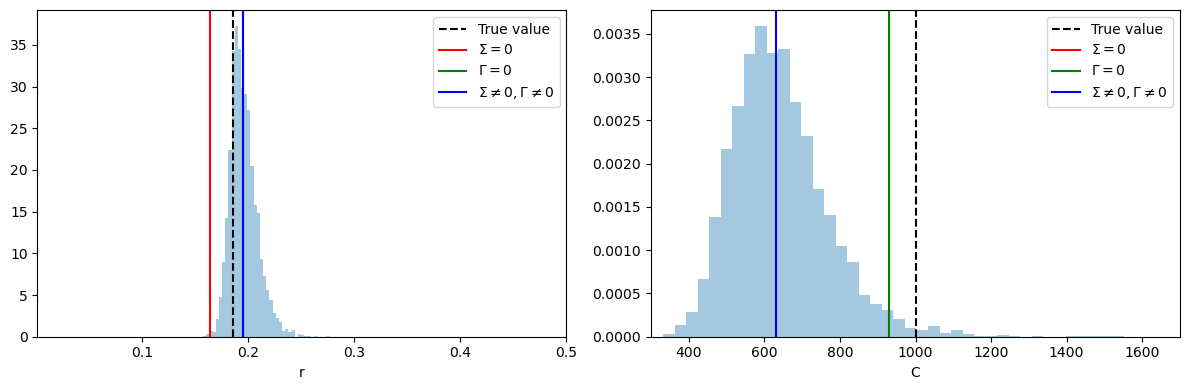

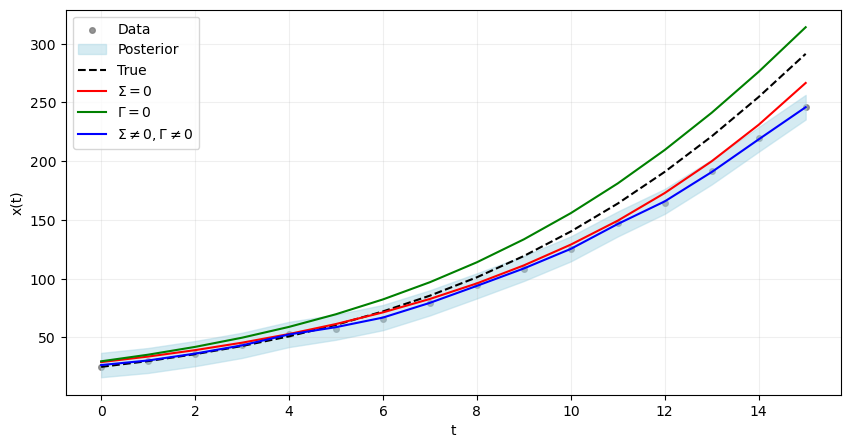


=== Table 1: RMSE ===
            Sigma = 0  Gamma = 0  Sigma != 0, Gamma != 0
Train RMSE   7.235892  31.955663                0.788235
Test RMSE   39.776648  74.531199               27.368947


In [281]:
allresults = allestimations(N=20,sigma=5.0, samples=5000, thining=5, burnin=500, datasets=datasets)

Sigma = 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [00:03<00:00, 6547.10 draws/s]


Gamma = 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [00:04<00:00, 5110.15 draws/s]


Sigma != 0, Gamma != 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [08:54<00:00, 47.69 draws/s]


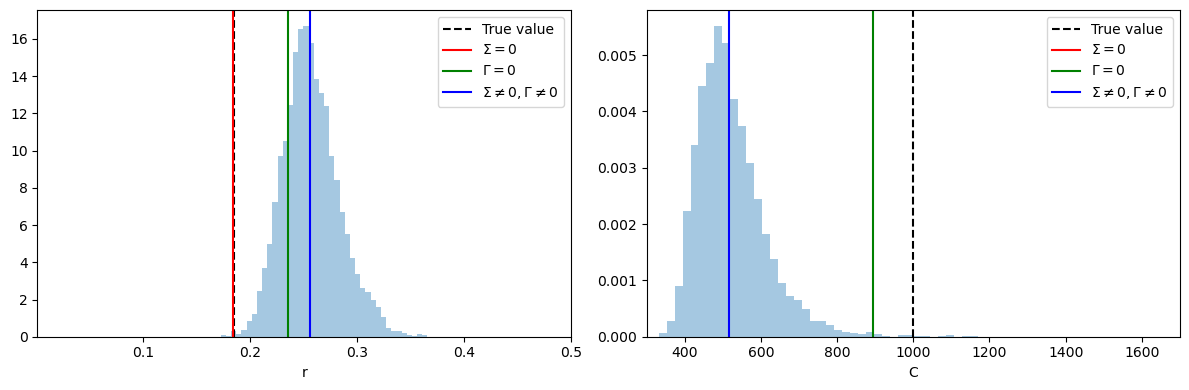

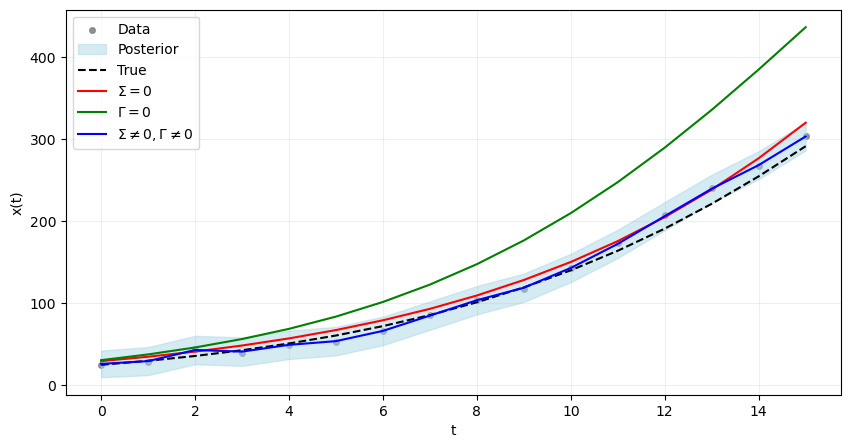


=== Table 1: RMSE ===
            Sigma = 0   Gamma = 0  Sigma != 0, Gamma != 0
Train RMSE   8.776428   64.759604                0.896389
Test RMSE   39.239698  144.442460               50.338772


In [284]:
allresults = allestimations(N=20,sigma=25.0, samples=5000, thining=5, burnin=500, datasets=datasets)

Sigma = 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [00:06<00:00, 3726.70 draws/s]


Gamma = 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [00:08<00:00, 2939.32 draws/s]


Sigma != 0, Gamma != 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [21:04<00:00, 20.16 draws/s]


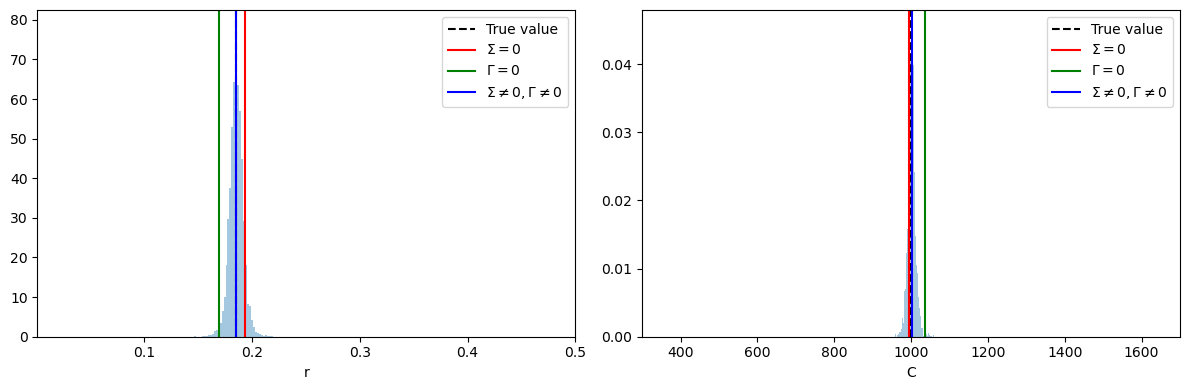

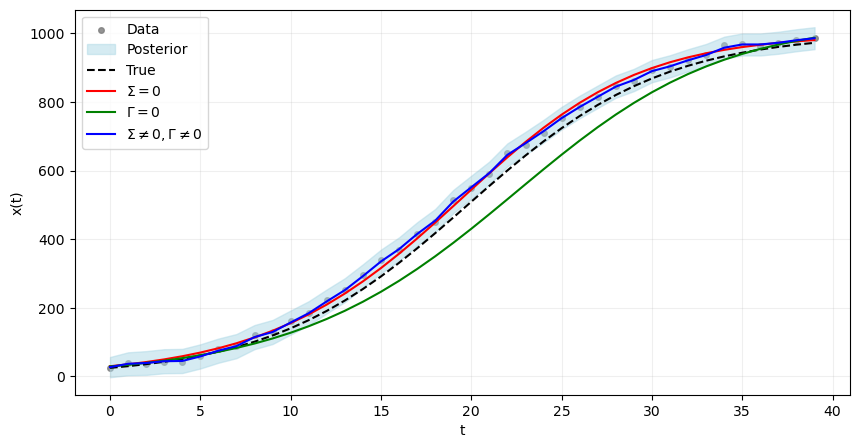


=== Table 1: RMSE ===
            Sigma = 0  Gamma = 0  Sigma != 0, Gamma != 0
Train RMSE  10.670697  68.930625                3.049183
Test RMSE   13.259034  30.527003               13.924885


In [ ]:
allresults = allestimations(N=50,sigma=5.0, samples=5000, thining=5, burnin=500, datasets=datasets)

Sigma = 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [00:06<00:00, 3718.14 draws/s]


Gamma = 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [00:08<00:00, 2920.14 draws/s]


Sigma != 0, Gamma != 0 estimation


Sampling progress: 100%|██████████| 25500/25500 [21:44<00:00, 19.54 draws/s]


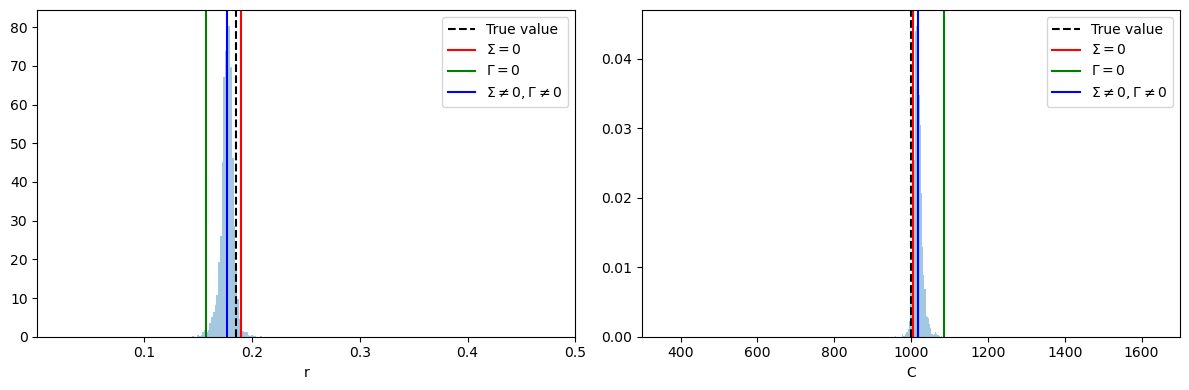

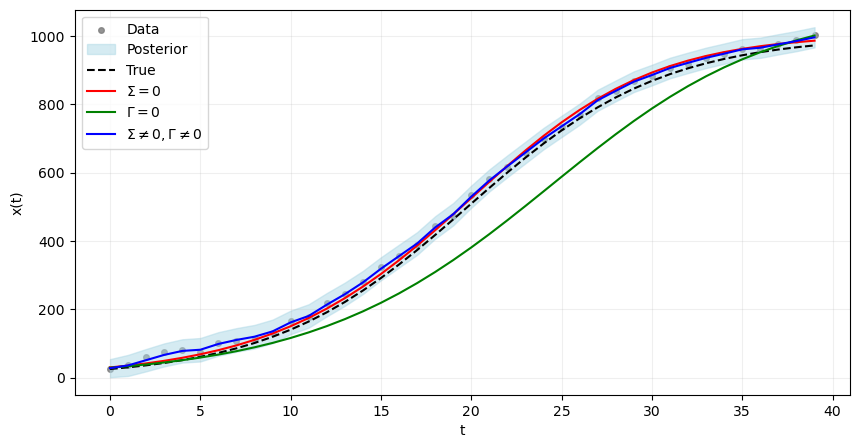


=== Table 1: RMSE ===
            Sigma = 0  Gamma = 0  Sigma != 0, Gamma != 0
Train RMSE  11.169649  91.551043                3.540593
Test RMSE   16.342381  65.900608               26.062554


In [283]:
allresults = allestimations(N=50,sigma=25.0, samples=5000, thining=5, burnin=500, datasets=datasets)